# Tutorial 4 – Simulation of Advanced Reaction system with Algebraic equations

Now that complementary states are understood we can explain perhaps the most conceptually difficult part in KIPET, the idea of algebraic variables. The terms algebraics and algebraic variables are used in KIPET when referring to equations and variables in larger models that can be used to determine the ODEs where we have a number of states and equations. This can be illustrated with the Aspirin case study from Chen et al. (2016) where we have the more complex reaction mechanism:

<div>
<img src="../../../documentation/content/ex4eq1.png" width="400"/>
</div>

With the rate laws being:

<div>
<img src="../../../documentation/content/ex4eq2.png" width="400"/>
</div>

And these can then be used to describe the concentrations of the liquid and solid components with the ODEs:

<div>
<img src="../../../documentation/content/ex4eq3.png" width="425"/>
</div>

### Load required modules

In [4]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from kipet.library.common.charts import make_plot
from kipet.library.data_tools import *
from kipet.library.ParameterEstimator import *
from kipet.library.PyomoSimulator import *
from kipet.library.TemplateBuilder import *
from kipet.library.VarianceEstimator import *

### Read and Prepare Data

Several files are needed for this example.

The external files are the csv’s and the option index_col is from pandas and refers to the column to use for the labels. Following this, external files are also used for the flow of water fed into the reactor, as well as the saturation concentrations of SA and ASA (functions of temperature, calculated externally).

In [7]:
dataDirectory = os.path.abspath(
    os.path.join( os.path.dirname( os.path.abspath( inspect.getfile(
        inspect.currentframe() ) ) ), '..', 'data_sets'))
traj =  os.path.join(dataDirectory, 'extra_states.txt')
conc =  os.path.join(dataDirectory,'concentrations.txt')    

fixed_traj = read_absorption_data_from_txt(traj)
C = read_absorption_data_from_txt(conc)

meas_times=sorted(C.index)

# How many measurement times are there
nfe_x = len(meas_times)

read dir : /home/kevin/Dev/kipet/kipet/examples/data_sets/extra_states.txt
read dir : /home/kevin/Dev/kipet/kipet/examples/data_sets/concentrations.txt


This example can be described by the equations 35 (which are the “algebraics” in KIPET) and the ODEs, equations 36. which will then be the ODEs defining the system, making use of the reaction rate laws from the algebraics. Translating these equations into code for KIPET we get the file found in Ex_4_sim_aspirin. In this example we need to declare new sets of states in addition to our components and parameters, as with Tutorial 3:

In [10]:
builder = TemplateBuilder()

# components
components = dict()
components['SA'] = 1.0714                  # Salicitilc acid
components['AA'] = 9.3828                  # Acetic anhydride
components['ASA'] = 0.0177                 # Acetylsalicylic acid
components['HA'] = 0.0177                  # Acetic acid
components['ASAA'] = 0.000015              # Acetylsalicylic anhydride
components['H2O'] = 0.0                    # Water

builder.add_mixture_component(components)

# add parameters
params = dict()
params['k0'] = 0.0360309
params['k1'] = 0.1596062
params['k2'] = 6.8032345
params['k3'] = 1.8028763
params['kd'] = 7.1108682
params['kc'] = 0.7566864
params['Csa'] = 2.06269996

builder.add_parameter(params)

# add additional state variables
extra_states = dict()
extra_states['V'] = 0.0202
extra_states['Masa'] = 0.0
extra_states['Msa'] = 9.537

builder.add_complementary_state_variable(extra_states)

with the initial values given. In addition we can declare our algebraic variables (the rate variables and other algebraics):

In [ ]:
algebraics = ['f','r0','r1','r2','r3','r4','r5','v_sum','Csat']
builder.add_algebraic_variable(algebraics)

Where f represents the addition of liquid to the reactor during the batch reaction. For the final equation in the model (Equn 36) we also need to define the stoichiometric coefficients, gammas, and the epsilon for how the added water affects the changes in volume.

In [11]:
gammas = dict()
gammas['SA']=    [-1, 0, 0, 0, 1, 0]
gammas['AA']=    [-1,-1, 0,-1, 0, 0]
gammas['ASA']=   [ 1,-1, 1, 0, 0,-1]
gammas['HA']=    [ 1, 1, 1, 2, 0, 0]
gammas['ASAA']=  [ 0, 1,-1, 0, 0, 0]
gammas['H2O']=   [ 0, 0,-1,-1, 0, 0]


epsilon = dict()
epsilon['SA']= 0.0
epsilon['AA']= 0.0
epsilon['ASA']= 0.0
epsilon['HA']= 0.0
epsilon['ASAA']= 0.0
epsilon['H2O']= 1.0

partial_vol = dict()
partial_vol['SA']=0.0952552311614
partial_vol['AA']=0.101672206869
partial_vol['ASA']=0.132335206093
partial_vol['HA']=0.060320218688
partial_vol['ASAA']=0.186550717015
partial_vol['H2O']=0.0883603912169

To define the algebraic equations in Equn (35) we then use:

In [12]:
def rule_algebraics(m,t):
    r = list()
    r.append(m.Y[t,'r0']-m.P['k0']*m.Z[t,'SA']*m.Z[t,'AA'])
    r.append(m.Y[t,'r1']-m.P['k1']*m.Z[t,'ASA']*m.Z[t,'AA'])
    r.append(m.Y[t,'r2']-m.P['k2']*m.Z[t,'ASAA']*m.Z[t,'H2O'])
    r.append(m.Y[t,'r3']-m.P['k3']*m.Z[t,'AA']*m.Z[t,'H2O'])

    # dissolution rate
    step = 1.0/(1.0+exp(-m.X[t,'Msa']/1e-4))
    rd = m.P['kd']*(m.P['Csa']-m.Z[t,'SA']+1e-6)**1.90*step
    r.append(m.Y[t,'r4']-rd)
    #r.append(m.Y[t,'r4'])

    # crystalization rate
    diff = m.Z[t,'ASA'] - m.Y[t,'Csat']
    rc = 0.3950206559*m.P['kc']*(diff+((diff)**2+1e-6)**0.5)**1.34
    r.append(m.Y[t,'r5']-rc)

    Cin = 39.1
    v_sum = 0.0
    V = m.X[t,'V']
    f = m.Y[t,'f']
    for c in m.mixture_components:
        v_sum += partial_vol[c]*(sum(gammas[c][j]*m.Y[t,'r{}'.format(j)] for j in range(6))+ epsilon[c]*f/V*Cin)
    r.append(m.Y[t,'v_sum']-v_sum)

    return r

builder.set_algebraics_rule(rule_algebraics)

Where the algebraics are given the variable name m.Y[t,’r1’]. We can then use these algebraic equations to define our system of ODEs:

In [ ]:
def rule_odes(m,t):
    exprs = dict()

    V = m.X[t,'V']
    f = m.Y[t,'f']
    Cin = 41.4
    # volume balance
    vol_sum = 0.0
    for c in m.mixture_components:
        vol_sum += partial_vol[c]*(sum(gammas[c][j]*m.Y[t,'r{}'.format(j)] for j in range(6))+ epsilon[c]*f/V*Cin)
    exprs['V'] = V*m.Y[t,'v_sum']

    # mass balances
    for c in m.mixture_components:
        exprs[c] = sum(gammas[c][j]*m.Y[t,'r{}'.format(j)] for j in range(6))+ epsilon[c]*f/V*Cin - m.Y[t,'v_sum']*m.Z[t,c]

    exprs['Masa'] = 180.157*V*m.Y[t,'r5']
    exprs['Msa'] = -138.121*V*m.Y[t,'r4']
    return exprs

builder.set_odes_rule(rule_odes)

model = builder.create_pyomo_model(0.0,210.5257)  

The rest can then be defined in the same way as other simulation problems. Note that in this problem the method for providing initializations from an external file is also shown with the lines:

In [13]:
sim = PyomoSimulator(model)
# defines the discrete points wanted in the concentration profile
sim.apply_discretization('dae.collocation',nfe=100,ncp=3,scheme='LAGRANGE-RADAU')
fe_l = sim.model.alltime.get_finite_elements()
fe_list = [fe_l[i + 1] - fe_l[i] for i in range(0, len(fe_l) - 1)]
nfe = len(fe_list)  #: Create a list with the step-size
print(nfe)

filename_initZ = os.path.join(dataDirectory, 'init_Z.csv')#Use absolute paths
initialization = pd.read_csv(filename_initZ, index_col=0)
sim.initialize_from_trajectory('Z', initialization)
filename_initX = os.path.join(dataDirectory, 'init_X.csv')#Use absolute paths
initialization = pd.read_csv(filename_initX, index_col=0)
sim.initialize_from_trajectory('X', initialization)
filename_initY = os.path.join(dataDirectory, 'init_Y.csv')#Use absolute paths
initialization = pd.read_csv(filename_initY, index_col=0)
sim.initialize_from_trajectory('Y', initialization)

sim.fix_from_trajectory('Y', 'Csat', fixed_traj)
sim.fix_from_trajectory('Y', 'f', fixed_traj)

with open("f0.txt", "w") as f:
    for t in sim.model.alltime:
        val = value(sim.model.Y[t, 'f'])
        f.write('\t' + str(t) + '\t' + str(val) + '\n')
    f.close()


options = {'halt_on_ampl_error' :'yes'}
results = sim.run_sim('ipopt',
                      tee=True,
                      solver_opts=options)

100
Ipopt 3.13.2: halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    34534
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5409

Total number of variables............................:     7516
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:   

### Visualization of Results

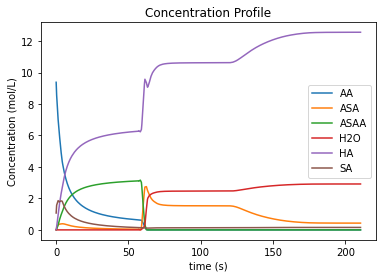

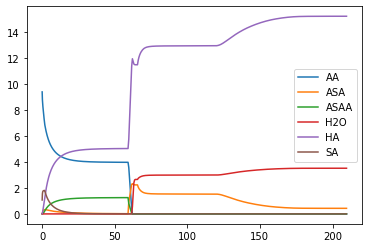

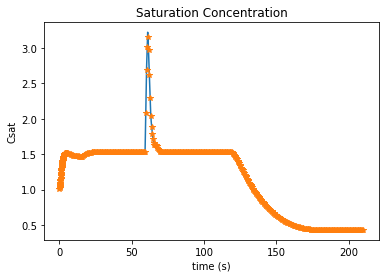

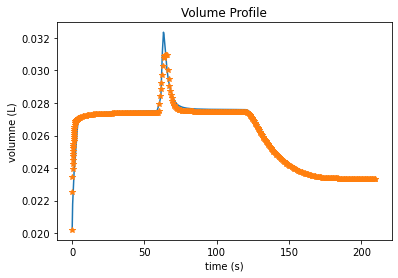

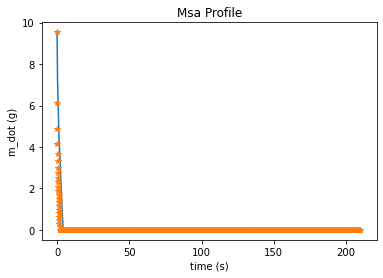

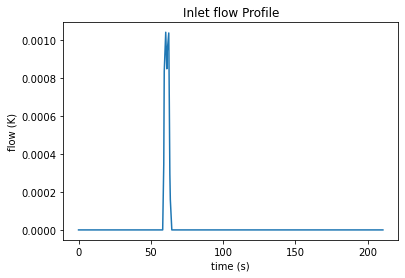

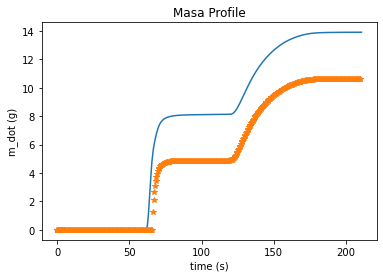

In [15]:
results.Z.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")

C.plot()

plt.figure()

results.Y['Csat'].plot.line()
plt.plot(fixed_traj['Csat'],'*')
plt.xlabel("time (s)")
plt.ylabel("Csat")
plt.title("Saturation Concentration")

plt.figure()

results.X['V'].plot.line()
plt.plot(fixed_traj['V'],'*')
plt.xlabel("time (s)")
plt.ylabel("volumne (L)")
plt.title("Volume Profile")

plt.figure()

results.X['Msa'].plot.line()
plt.plot(fixed_traj['Msa'],'*')
plt.xlabel("time (s)")
plt.ylabel("m_dot (g)")
plt.title("Msa Profile")

plt.figure()
results.Y['f'].plot.line()
plt.xlabel("time (s)")
plt.ylabel("flow (K)")
plt.title("Inlet flow Profile")

plt.figure()
results.X['Masa'].plot.line()
plt.plot(fixed_traj['Masa'],'*')
plt.xlabel("time (s)")
plt.ylabel("m_dot (g)")
plt.title("Masa Profile")

plt.show()